In [1]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
numpy2ri.activate()
pandas2ri.activate()

In [3]:
def model(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset


def model_prob(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset

def generate_data(group='PROB_CON', sample_size=1, n_sites=2, randseed=3):
    np.random.seed(randseed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            if prob:
                score = model_prob(age, sex, site[1]['score_shift'])
            else:
                score = model(age, sex, site[1]['score_shift'])
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'group', 'age', 'score'])
    df.sex.replace({1: 'Female', 0: 'Male'}, inplace=True)
    if group == 'PROB_CON':
        df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
    return df

In [4]:
df = generate_data(n_sites=5,sample_size=35,randseed=650)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 878


Text(0.5, 1.0, 'By sex')

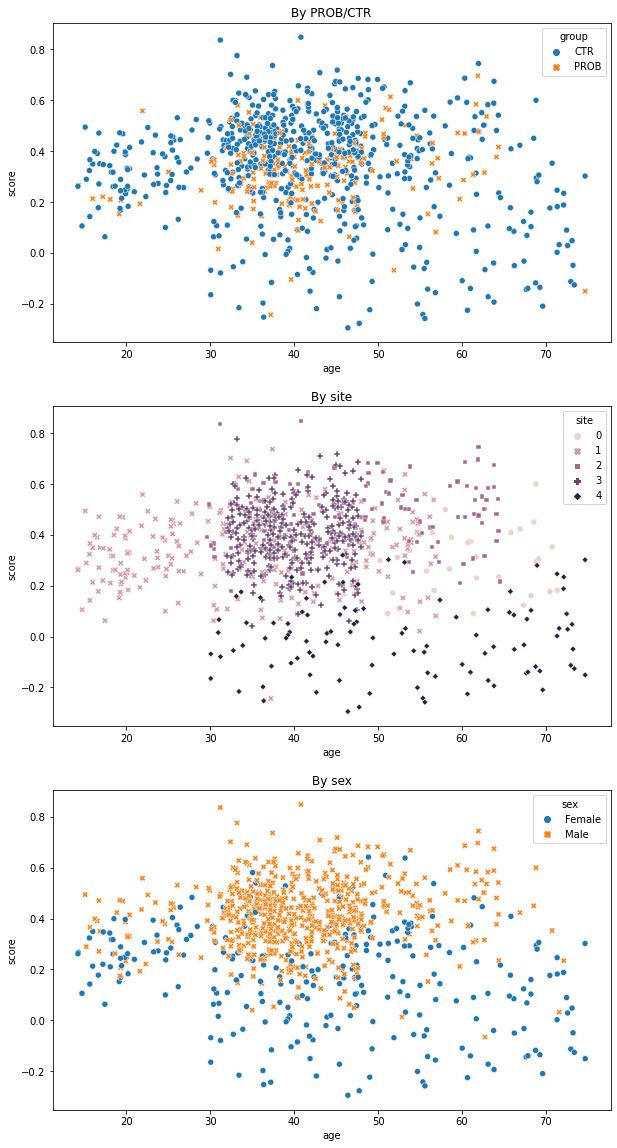

In [5]:
fig,ax = plt.subplots(3,1,figsize=(10,20))

sns.scatterplot(data=df, x='age', y='score', hue='group', style='group',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

In [6]:
df.head()

,site,sex,group,age,score
0,0,Female,CTR,65.818713,0.409020
1,0,Female,CTR,68.827045,0.294608
2,0,Male,CTR,61.660016,0.313654
3,0,Male,CTR,66.886592,0.423175
4,0,Male,CTR,55.738248,0.257225


In [7]:
#utils = importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages('gamlss')

gamlss_data = importr('gamlss.data',lib_loc='/home/harveyaa/R/x86_64-pc-linux-gnu-library/3.6/')
gamlss_dist = importr('gamlss.dist',lib_loc='/home/harveyaa/R/x86_64-pc-linux-gnu-library/3.6/')
gamlss = importr('gamlss',lib_loc='/home/harveyaa/R/x86_64-pc-linux-gnu-library/3.6/')

In [8]:
NO = r['NO']
SHASHo2 = r['SHASHo2']
formula = r['formula']
predict = r['predict']
predict_gamlss = gamlss.predict_gamlss

In [18]:
liss = ['A','B','C']
'+'.join(liss)

'A+B+C'

In [15]:
f1 = formula('score~age+C(sex)+site')
g1 = gamlss.gamlss(f1,
                    sigma_formula = formula('~ 1'),
                    nu_formula = formula('~ 1'),
                    tau_formula = formula('~ 1'),
                    data=df,
                    family=SHASHo2)

R[write to console]: Error in C(sex) : object not interpretable as a factor
Calls: <Anonymous> ... model.frame -> model.frame.default -> eval -> eval -> C

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In RS() :
R[write to console]:  Algorithm RS has not yet converged



RRuntimeError: Error in C(sex) : object not interpretable as a factor
Calls: <Anonymous> ... model.frame -> model.frame.default -> eval -> eval -> C


In [54]:
A = np.random.uniform(0,100,5)
newdata = pd.DataFrame(A,columns=['age'])
predict_gamlss(g1,newdata=newdata)

array([ 0.27915037,  0.27630352, -0.76076381, -0.26701869, -0.34897147])

In [56]:
df['score'].describe()

count    878.000000
mean       0.341081
std        0.188264
min       -0.294753
25%        0.251868
50%        0.369380
75%        0.468278
max        0.848207
Name: score, dtype: float64

In [40]:
g1_python = dict(zip(g1.names,list(g1)))
g1_python['residuals'].shape

(878,)

In [26]:
x_test = np.random.randn(10)
predict(g1,x_test)

R[write to console]: Error in match.arg(what) : 'arg' must be NULL or a character vector
Calls: <Anonymous> -> predict.gamlss -> lpred -> match.arg



RRuntimeError: Error in match.arg(what) : 'arg' must be NULL or a character vector
Calls: <Anonymous> -> predict.gamlss -> lpred -> match.arg


In [61]:
cs = r['cs']
f2 = formula('score~cs(x,df=3)')
g2 = gamlss.gamlss(f2,data=df,family=NO())

GAMLSS-RS iteration 1: Global Deviance = 1770.067 
GAMLSS-RS iteration 2: Global Deviance = 1770.067 


In [63]:
predict = r['predict']
predict(g2,what='sigma',type='response')[1]

0.5863109588633391

In [19]:
fakef = 'var1 ~ f(var2*var3) + beeopooo'

In [21]:
fakef.split('~')[1]

' f(var2*var3) + beeopooo'

In [70]:
resid = r['residuals']
resid(g3)

array([-2.38704391e+00, -1.20444985e-01,  2.77362893e-01,  9.19865731e-02,
        9.76881368e-01,  8.63147812e-01,  8.40354693e-01,  9.86139611e-01,
        6.80144323e-01, -1.80452297e+00,  2.28242809e-02,  1.41148279e+00,
        1.41712566e-01, -4.03387622e-01,  1.53023265e+00,  1.57820853e+00,
        1.02675578e+00, -5.04893617e-01,  6.69146432e-01,  9.38183780e-01,
       -8.47353408e-01, -6.80962776e-01, -1.28056403e+00,  7.15260800e-01,
       -3.90037914e-01, -1.65556282e-01, -1.98164458e+00,  1.38765401e-01,
       -4.44314111e-01, -6.96634388e-01, -6.00754726e-01,  2.38821198e+00,
       -1.03212532e+00,  3.17188011e-01, -2.79026821e-01,  5.34448467e-01,
       -1.58012341e+00,  6.69511463e-01, -2.13453005e-01,  1.99097848e+00,
       -2.95223910e-01, -3.36964886e-01, -6.83964516e-01,  8.89793270e-01,
       -1.02000863e+00, -5.76303299e-01,  1.72770831e+00,  7.17115406e-01,
        2.01490699e-01,  4.28974527e-01,  2.11455285e+00, -4.27558079e-01,
       -3.28042101e-01, -

In [74]:
plot = r['plot']
plot(g3)

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -0.003772006 
                       variance   =  1.000987 
               coef. of skewness  =  0.01337103 
               coef. of kurtosis  =  2.977382 
Filliben correlation coefficient  =  0.9993427 
******************************************************************


mfrow,[RTYPES.INTSXP]
mar,[RTYPES.REALSXP]
col.axis,[RTYPES.STRSXP]
col.main,[RTYPES.STRSXP]
col.lab,[RTYPES.STRSXP]
col,[RTYPES.STRSXP]
bg,[RTYPES.STRSXP]


In [9]:
SHASHo2 = r['SHASHo2']
g4 = gamlss.gamlss(formula('score~lo(~x,span=.4)'),
                    sigma_formula=formula('~lo(~x,span=.4)'),
                    data=df,
                    family=SHASHo2)

GAMLSS-RS iteration 1: Global Deviance = 1896.31 
GAMLSS-RS iteration 2: Global Deviance = 1699.117 
GAMLSS-RS iteration 3: Global Deviance = 1641.989 
GAMLSS-RS iteration 4: Global Deviance = 1620.39 
GAMLSS-RS iteration 5: Global Deviance = 1610.704 
GAMLSS-RS iteration 6: Global Deviance = 1606.056 
GAMLSS-RS iteration 7: Global Deviance = 1603.426 
GAMLSS-RS iteration 8: Global Deviance = 1601.943 
GAMLSS-RS iteration 9: Global Deviance = 1601.043 
GAMLSS-RS iteration 10: Global Deviance = 1600.468 
GAMLSS-RS iteration 11: Global Deviance = 1600.083 
GAMLSS-RS iteration 12: Global Deviance = 1599.868 
GAMLSS-RS iteration 13: Global Deviance = 1599.673 
GAMLSS-RS iteration 14: Global Deviance = 1599.506 
GAMLSS-RS iteration 15: Global Deviance = 1599.395 
GAMLSS-RS iteration 16: Global Deviance = 1599.313 
GAMLSS-RS iteration 17: Global Deviance = 1599.253 
GAMLSS-RS iteration 18: Global Deviance = 1599.209 
GAMLSS-RS iteration 19: Global Deviance = 1599.174 
GAMLSS-RS iteration 20:

In [81]:
AIC = r['AIC']
AIC(g2,g3,g4,k=3)

,df,AIC


In [10]:
r('''
 matcal <- function(mat) {
 s = sum(mat)
 sigma = sd(mat)
 return(c(s,sigma))
 }
''')
## This function can now be accessed with the __getitem__ mechanins
r_matcal = robjects.globalenv['matcal']
print(r_matcal.r_repr())

function (mat) 
{
    s = sum(mat)
    sigma = sd(mat)
    return(c(s, sigma))
}


In [17]:
A = np.random.randn(3,3)
r_matcal(A)

-3.113474,1.006387


In [ ]:
summary = r['summary']
summary(g)